# 1.1 Load libraries

Note: After resolving conflicts, runs the entire notebook to make sure none of the old code is broken.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import os
from scipy.stats import norm, binom
import warnings
warnings.filterwarnings("ignore")

from pypfopt import EfficientFrontier, risk_models, expected_returns, objective_functions, base_optimizer, black_litterman, discrete_allocation

# 1.2 Load the stocks into memory and perform some preprocessing steps

The data is stored as key-value pairs in a dictionary, with the ticker referencing the respective dataframe. Following that, the date is changed into a datetime object and a new column for log-returns is added.

In [2]:
# load stocks into a dictionary
stocks = {}
do_not_append = ['FSELX','IPHI', '005930'] # FSELX is our fund, while IPHI does not have data and has been bought over by MRVL. 005930 non-USD.  'ASX', 'NXPI', 'TSM' companies are not based in the US but traded in US markets
for file_name in os.listdir('best_data/'):
  ticker = file_name.split(".")[0]
  if ticker in do_not_append:
    pass
  else:
    stocks[f'{ticker}'] = pd.read_csv(f'best_data/{file_name}') # for each stock, add its ticker as the key and dataframe as the value

In [3]:
print(list(stocks.keys())) # print the stock tickers for easy referencing

['ADI', 'AEIS', 'AMAT', 'AMBA', 'AMD', 'AOSL', 'ASX', 'AVGO', 'CRUS', 'DIOD', 'ENPH', 'FLEX', 'IIVI', 'INTC', 'JBL', 'LRCX', 'MCHP', 'MRVL', 'MTSI', 'MU', 'MXL', 'NVDA', 'NXPI', 'OLED', 'ON', 'QCOM', 'SEDG', 'SGH', 'SMTC', 'SYNA', 'TSM', 'TTMI', 'TXN', 'XLNX']


In [4]:
# Change date column into a datetime object
# Add a new column for log returns
for ticker, df in stocks.items():
  df['Date'] = df['Date'].apply(pd.to_datetime)
  df['LogReturns'] = np.append(np.nan,np.diff(np.log(df['Adj Close']))) # Fill dataframe with the log returns. The first value will be nan because there is no log returns for it.

In [5]:
# preview a stock
stocks['TXN'].head()

,Date,Open,High,Low,Close,Adj Close,Volume,LogReturns
0,2016-10-04,69.660004,69.910004,69.099998,69.589996,61.006310,4089500,NaN
1,2016-10-05,69.849998,70.839996,69.010002,70.599998,61.891724,4789600,0.014409
2,2016-10-06,70.440002,71.000000,70.029999,70.959999,62.207321,4061500,0.005086
3,2016-10-07,71.000000,71.059998,70.449997,70.870003,62.128426,3673600,-0.001269
4,2016-10-10,71.080002,71.330002,69.900002,69.930000,61.304375,4893200,-0.013352


In [6]:
top_30 = ['SYNA', 'MRVL', 'SGH', 'ENPH', 'JBL', 'CRUS', 'MCHP', 'AEIS', 'MTSI', 'AMAT', 'NVDA', 'ON', 'TTMI', 'SMTC', 'AVGO', 'XLNX', 'TSM', 'IIVI', 'QCOM', 'NXPI', 'FLEX', 'DIOD', 'AMD', 'MXL', 'ADI', 'INTC', 'TXN', 'LRCX', 'MU', 'OLED']
stocks_30 = {stock:df for stock,df in stocks.items() if stock in top_30}

# 1.3 Aggregate the returns into one dataframe

In [7]:
log_returns = pd.DataFrame(data=np.full((stocks['TXN'].shape[0],30),np.nan), columns = sorted(list(stocks_30.keys())), index = stocks_30['TXN'].Date) # create empty dataframe filled with NaNs, with index = Date and columns = stocks

# copy the log returns over from the stocks dictionary
for ticker, df in stocks_30.items():
  log_returns[ticker] = log_returns.index.map(stocks_30[ticker].set_index('Date')['LogReturns'])

# if simple returns are needed
simple_returns = np.exp(log_returns)-1
#simple_returns['RF'] = np.repeat(0.01/252,simple_returns.shape[0])

In [8]:
# preview log_returns
simple_returns.head()

,ADI,AEIS,AMAT,AMD,AVGO,CRUS,DIOD,ENPH,FLEX,IIVI,...,OLED,ON,QCOM,SGH,SMTC,SYNA,TSM,TTMI,TXN,XLNX
Date,,,,,,,,,,,,,,,,,,,,,
2016-10-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-05,0.006849,0.008323,0.011145,-0.027260,0.026205,0.018109,0.024402,-0.008333,0.030837,0.043100,...,-0.006262,0.018062,0.002399,NaN,0.008727,0.049058,0.004607,0.019164,0.014513,0.006596
2016-10-06,0.000928,0.027513,-0.001670,0.026549,0.004093,0.012919,0.003270,0.016807,0.004986,0.026619,...,0.003819,0.002419,0.010473,NaN,-0.002884,0.054531,0.007861,0.001709,0.005099,0.000375
2016-10-07,-0.004943,-0.015448,-0.004684,-0.030172,0.000115,-0.000739,-0.016760,-0.041322,-0.000709,-0.005418,...,-0.000761,-0.012068,0.009624,NaN,-0.004700,0.017339,0.013325,0.014505,-0.001268,-0.010107
2016-10-10,-0.016610,0.004184,-0.012437,0.013333,0.003214,0.023122,-0.007102,-0.086207,-0.004965,0.003891,...,0.013707,-0.012215,-0.013785,NaN,-0.027243,0.014630,0.003207,0.000000,-0.013264,-0.012857


The stock SGH has a lot of NaN values. We take a closer look at it.

In [9]:
# preview SGH
stocks['SGH'].head()

,Date,Open,High,Low,Close,Adj Close,Volume,LogReturns
0,2017-05-24,12.00,14.000,11.50,13.45,13.45,1415200,NaN
1,2017-05-25,13.85,14.320,13.35,13.50,13.50,237900,0.003711
2,2017-05-26,13.36,13.624,12.46,13.23,13.23,56200,-0.020203
3,2017-05-30,13.20,13.255,12.28,12.98,12.98,71200,-0.019077
4,2017-05-31,13.02,13.500,12.93,13.10,13.10,55700,0.009203


SGH only begins at a later date, explaining the NaNs we see in our earlier preview.}

# 1.4 Descriptive analytics of returns

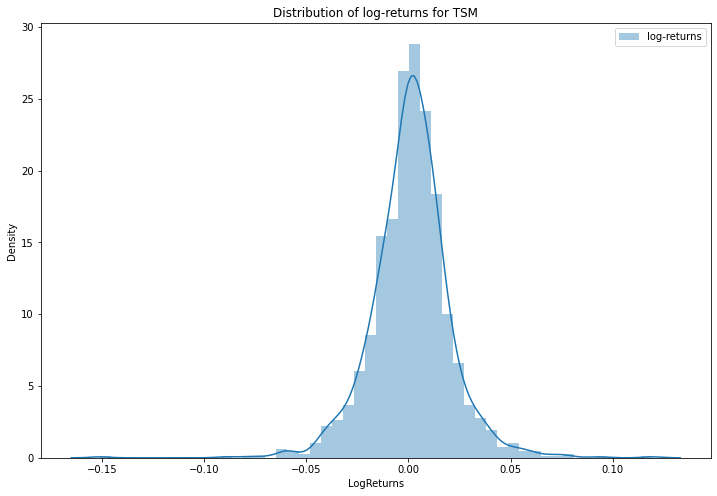

In [10]:
# We use TSM as an example
plt.figure(figsize=(12,8))
sns.distplot(stocks['TSM']['LogReturns'], kde=True, label='log-returns')
plt.legend()
plt.title("Distribution of log-returns for TSM")
plt.show()

In [11]:
returns_kurtosis = stocks['TSM']['LogReturns'].kurtosis()
returns_skew = stocks['TSM']['LogReturns'].skew()
print(f"Kurtosis: {returns_kurtosis}")
print(f"Skew: {returns_skew}")

Kurtosis: 5.739522840966442
Skew: -0.20199323738019406


# 2.1 Optimization

In [12]:
original_portfolio = pd.read_csv('original_weights_best.csv')
#original_portfolio['Security\'s Percentage of the Total Net Assets'] = np.round(original_portfolio['Security\'s Percentage of the Total Net Assets'],3)/100
original_portfolio.index = original_portfolio['Ticker Symbol Given by the Exchange']
del original_portfolio['Ticker Symbol Given by the Exchange']
original_portfolio = original_portfolio.loc[top_30,]

In [13]:
# normalize top 30 weights
original_portfolio['Security\'s Percentage of the Total Net Assets'] = (original_portfolio['Security\'s Percentage of the Total Net Assets']/original_portfolio['Security\'s Percentage of the Total Net Assets'].sum())

In [14]:
# drop nans
simple_returns = simple_returns.dropna()

# get in-sample time window to perform optimization on (inclusive)
is_start_date = '2019-6-30'
is_end_date = '2020-6-30'

# get out-of-sample time window for evaluation (inclusive)
oos_start_date = '2020-7-1'
oos_end_date = '2020-12-31'

in_sample_window = simple_returns[(simple_returns.index>=is_start_date)&(simple_returns.index<=is_end_date)].copy()
out_sample_window = simple_returns[(simple_returns.index>=oos_start_date)&(simple_returns.index<=oos_end_date)].copy()

In [15]:
# create dataframe to store results
pd.DataFrame(np.zeros(len(in_sample_window.columns)+1),index = np.append(in_sample_window.columns.values,'RF'))

comparison_table = pd.DataFrame(original_portfolio['Security\'s Percentage of the Total Net Assets'])
comparison_table = comparison_table.rename(columns={'Security\'s Percentage of the Total Net Assets':'original weights'})
comparison_table.loc['RF','original weights'] = 0

In [16]:
# Calculate expected returns and sample covariance using PyPortfolioOpt’s built-in methods
mu = expected_returns.mean_historical_return(in_sample_window, returns_data=True)
mu['RF'] = 0.01 # add risk-free assets
S = risk_models.sample_cov(in_sample_window, returns_data=True)
S.loc['RF',:] = 0 # add risk-free assets
S.loc[:,'RF'] = 0

oos_mu = expected_returns.mean_historical_return(out_sample_window, returns_data=True)
oos_mu.loc['RF'] = 0.01 # add risk-free assets
oos_S = risk_models.sample_cov(out_sample_window, returns_data=True)
oos_S.loc['RF',:] = 0 # add risk-free assets
oos_S.loc[:,'RF'] = 0

#print('Expected Returns:')
#print(mu)
#print('\n')
#print('Covariance Matrix:')
#print(S)
solver = "ECOS"

## Approach 1 -- Simple implementation
* Simple sub-sectors, semiconductors and others
* Base-line

In [17]:
# Set each stock to a sub-sector 
# Until someone has a better idea, use:
semiconductors = ['ADI','AMAT','AMD','AVGO','CRUS',
                  'DIOD','INTC','LRCX','MCHP','MRVL',
                  'MTSI','MU','MXL','NVDA','NXPI',
                  'OLED','ON','QCOM','SGH','SMTC',
                  'SYNA','TSM','TXN','XLNX']
others = ['AEIS','ENPH','FLEX','JBL','TTMI', 
               'IIVI','RF'] # AEIS and IIVI are also in the semiconductor subsector, but just putting them here first since they're in both areas. Every stock here except for IIVI are in the electrical/electronics scene. RF = risk-free

**Calculating risk aversion**

$U=E(R)-k*std(R)^2$

Assuming a portfolio consisting only of the market portfolio + risk-free assets, and expressing $E(R)$ and $std(R)$ in terms of their weights, $w$, we have:

$U=0.1*w+0.01*(1-w) - k*(w*0.18)^2$

where $w$ is the weight allocated to the market portfolio. Then,

$dU/dw = -0.0648*w*k+0.099$

If we choose w = 1, and then solving for $dU/dw = 0$, we get $k=1.528$

In [18]:
ef = EfficientFrontier(mu, S, solver= solver)
k = 1.528 
print(f"k = {k}")

ef.add_constraint(lambda x: x >= 0) # weights >= 0
ef.add_constraint(lambda x: x <= 0.25) # weight <= 0.25

sector_mapper = {} # initialise sector_mapper
for stock in semiconductors:
  sector_mapper[stock] = 'semiconductors'
for stock in others:
  sector_mapper[stock] = 'others'

sector_lower = {'others': 0.3} # at least 30% to others

ef.add_sector_constraints(sector_mapper=sector_mapper, sector_lower=sector_lower, sector_upper={}) # add sector constraint

optimal_weights_portfolio = ef.max_quadratic_utility(risk_aversion = 2*k) # optimize by the quadratic utility function mean - k/2 * variance (hence the 2*k in the parameters)
print(ef.portfolio_performance(verbose=True, risk_free_rate=0.01))
results = pd.Series(np.array(list(optimal_weights_portfolio.values())),index = np.append(in_sample_window.columns, 'RF'))
print(np.round(results,4))
# check against out of sample window
_ = base_optimizer.portfolio_performance(results, oos_mu, oos_S, verbose=True, risk_free_rate=0.01)

k = 1.528
Expected annual return: 125.6%
Annual volatility: 53.6%
Sharpe Ratio: 2.32
(1.2555892515033344, 0.5360763269173904, 2.323529670981499)
ADI     0.00
AEIS    0.00
AMAT    0.00
AMD     0.00
AVGO    0.00
CRUS    0.00
DIOD    0.00
ENPH    0.25
FLEX    0.00
IIVI    0.00
INTC    0.00
JBL     0.00
LRCX    0.00
MCHP    0.00
MRVL    0.00
MTSI    0.25
MU      0.00
MXL     0.00
NVDA    0.25
NXPI    0.00
OLED    0.00
ON      0.00
QCOM    0.00
SGH     0.00
SMTC    0.00
SYNA    0.20
TSM     0.00
TTMI    0.00
TXN     0.00
XLNX    0.00
RF      0.05
dtype: float64
Expected annual return: 392.3%
Annual volatility: 37.8%
Sharpe Ratio: 10.35


In [19]:
comparison_table['1'] = np.round(results,2)

## Approach 2 -- Addressing the 0 weights problem the mean-variance optimization function causes
* Simple sub-sectors, semiconductors and others
* L2 regularization with gamma = 5

**From the pyportfolio webpage**

*In order to coerce the mean-variance optimizer to produce more non-negligible weights, we add what can be thought of as a “small weights penalty” to all of the objective functions, parameterised by γ (gamma).*

It is refered to as L2 regularisation despite having a different purpose from its usual use, to keep weights small. Here, is it used to keep weights bigger.

Note: Check different gamma values and portfolio's overall performance.

https://pyportfolioopt.readthedocs.io/en/latest/MeanVariance.html#pypfopt.objective_functions.L2_reg

In [20]:
# Set each stock to a sub-sector 
# Until someone has a better idea, use:
semiconductors = ['ADI','AMAT','AMD','AVGO','CRUS',
                  'DIOD','INTC','LRCX','MCHP','MRVL',
                  'MTSI','MU','MXL','NVDA','NXPI',
                  'OLED','ON','QCOM','SGH','SMTC',
                  'SYNA','TSM','TXN','XLNX']
others = ['AEIS','ENPH','FLEX','JBL','TTMI', 
               'IIVI','RF'] # AEIS and IIVI are also in the semiconductor subsector, but just putting them here first since they're in both areas. Every stock here except for IIVI are in the electrical/electronics scene. RF = risk-free

In [21]:
ef = EfficientFrontier(mu, S, solver= solver)
k = 1.528 
print(f"k = {k}")

ef.add_constraint(lambda x: x >= 0) # weights >= 0
ef.add_constraint(lambda x: x <= 0.25) # weight <= 0.25

sector_mapper = {} # initialise sector_mapper
for stock in semiconductors:
  sector_mapper[stock] = 'semiconductors'
for stock in others:
  sector_mapper[stock] = 'others'

sector_lower = {'others': 0.3} # at least 30% to others

ef.add_sector_constraints(sector_mapper=sector_mapper, sector_lower=sector_lower, sector_upper={}) # add sector constraint

ef.add_objective(objective_functions.L2_reg, gamma=5) # L2 regularisation parameter, defaults to 1. This adds a small weights penalty, gamma, to the objective function. Increase for more non-negligible weights. 

optimal_weights_portfolio = ef.max_quadratic_utility(risk_aversion = 2*k) # optimize by the quadratic utility function mean - k/2 * variance (hence the 2*k in the parameters)
print(ef.portfolio_performance(verbose=True, risk_free_rate=0.01))
results = pd.Series(np.array(list(optimal_weights_portfolio.values())),index = np.append(in_sample_window.columns, 'RF'))
print(np.round(results,4))
# check against out of sample window
_ = base_optimizer.portfolio_performance(results, oos_mu, oos_S, verbose=True, risk_free_rate=0.01)

k = 1.528
Expected annual return: 79.8%
Annual volatility: 45.4%
Sharpe Ratio: 1.74
(0.7982307492824275, 0.45427751747755246, 1.7351304410995354)
ADI     0.0021
AEIS    0.0155
AMAT    0.0166
AMD     0.0648
AVGO    0.0066
CRUS    0.0255
DIOD    0.0328
ENPH    0.1256
FLEX    0.0080
IIVI    0.0394
INTC    0.0246
JBL     0.0111
LRCX    0.0509
MCHP    0.0027
MRVL    0.0415
MTSI    0.1082
MU      0.0163
MXL     0.0000
NVDA    0.1170
NXPI    0.0025
OLED    0.0000
ON      0.0000
QCOM    0.0202
SGH     0.0000
SMTC    0.0000
SYNA    0.0966
TSM     0.0572
TTMI    0.0289
TXN     0.0140
XLNX    0.0000
RF      0.0715
dtype: float64
Expected annual return: 255.3%
Annual volatility: 29.7%
Sharpe Ratio: 8.57


In [22]:
comparison_table['2'] = np.round(results,2)

## Approach 3 -- Addressing small number of sub-sectors issue
- Sub-sectors by market cap, with floor = 20%, and ceiling = 50%
- using L2 regularization with gamma = 5

***Additionally, we can consider putting a stock of a company into multiple sub-sectors, if the company produces goods of a different sub-sector as well. This has yet to be implemented, though I might get to it if I have time.
If someone wants to pick up the mantle and do the research, please go ahead.***

In [23]:
# market cap by three categories, 100B+, 10B+, and 1B+
cat_1 = ["TSM", "NVDA", "INTC", "AVGO", "TXN", "QCOM", "AMD", "AMAT"] # 100B+ market cap
cat_2 = ["ADI", "MU", "LRCX", "MRVL", "NXPI", "MCHP", "XLNX", "ENPH", "ON"] # 10B+ market cap
cat_3 = ["JBL", "FLEX", "OLED", "SYNA", "IIVI", "SMTC", "CRUS", "MTSI", "DIOD", "MXL", "AEIS", "TTMI", "SGH"] # 1B+ market cap

In [24]:
ef = EfficientFrontier(mu, S, solver= solver)
k = 1.528 
print(f"k = {k}")

ef.add_constraint(lambda x: x >= 0) # weights >= 0
ef.add_constraint(lambda x: x <= 0.25) # weight <= 0.25

sector_mapper2 = {} # initialise sector_mapper
for stock in semiconductors:
  sector_mapper2[stock] = 'semiconductors'
for stock in others:
  sector_mapper2[stock] = 'others'

sector_lower2 = {'others': 0.3} # at least 30% to others

ef.add_sector_constraints(sector_mapper=sector_mapper2, sector_lower=sector_lower2, sector_upper={}) # add sector constraint

sector_mapper = {} # initialise sector_mapper
for stock in cat_1:
  sector_mapper[stock] = 'cat_1'
for stock in cat_2:
  sector_mapper[stock] = 'cat_2'
for stock in cat_3:
  sector_mapper[stock] = 'cat_3'
sector_mapper['RF'] = 'rf'

sector_lower = {'cat_1': 0.2, 'cat_2': 0.2, 'cat_3': 0.2} # at least 20% to each category
sector_upper = {'cat_1': 0.5, 'cat_2': 0.5, 'cat_3': 0.5} # not more than 50% to each category

ef.add_sector_constraints(sector_mapper=sector_mapper, sector_lower=sector_lower, sector_upper=sector_upper) # add sector constraint

ef.add_objective(objective_functions.L2_reg, gamma=5) # L2 regularisation parameter, defaults to 1. This adds a small weights penalty, gamma, to the objective function. Increase for more non-negligible weights. 

optimal_weights_portfolio = ef.max_quadratic_utility(risk_aversion = 2*k) # optimize by the quadratic utility function mean - k/2 * variance (hence the 2*k in the parameters)
ef.portfolio_performance(verbose=True, risk_free_rate=0.01) 
results = pd.Series(np.array(list(optimal_weights_portfolio.values())),index = np.append(in_sample_window.columns, 'RF'))
print(np.round(results,4))
print('\n')
print(f'CAT 1: {results.loc[cat_1].sum()}, CAT 2: {results.loc[cat_2].sum()}, CAT 3: {results.loc[cat_3].sum()}')
# check against out of sample window
_ = base_optimizer.portfolio_performance(results, oos_mu, oos_S, verbose=True, risk_free_rate=0.01)

k = 1.528
Expected annual return: 79.8%
Annual volatility: 45.4%
Sharpe Ratio: 1.74
ADI     0.0021
AEIS    0.0155
AMAT    0.0166
AMD     0.0648
AVGO    0.0066
CRUS    0.0255
DIOD    0.0328
ENPH    0.1256
FLEX    0.0080
IIVI    0.0394
INTC    0.0246
JBL     0.0111
LRCX    0.0509
MCHP    0.0027
MRVL    0.0415
MTSI    0.1082
MU      0.0163
MXL     0.0000
NVDA    0.1170
NXPI    0.0025
OLED    0.0000
ON      0.0000
QCOM    0.0202
SGH     0.0000
SMTC    0.0000
SYNA    0.0966
TSM     0.0572
TTMI    0.0289
TXN     0.0140
XLNX    0.0000
RF      0.0715
dtype: float64


CAT 1: 0.32089577475938735, CAT 2: 0.2415998283837197, CAT 3: 0.36600189012820383
Expected annual return: 255.3%
Annual volatility: 29.7%
Sharpe Ratio: 8.57


In [25]:
comparison_table['3'] = np.round(results,2)

## Approach 4 -- Adjusting the return and variance to be more realistic
- L2 regularization with gamma = 10, 5 has too many zero weights
- Exponentially weighted mean return and variance
- Sub-sectors by market cap


In [26]:
adj_mu = expected_returns.ema_historical_return(in_sample_window, span=252, returns_data=True)
adj_mu['RF'] = 0.01

adj_S = risk_models.exp_cov(in_sample_window,span=252,returns_data=True)

adj_S.loc['RF',:] = 0 # add risk-free assets
adj_S.loc[:,'RF'] = 0

In [27]:
ef = EfficientFrontier(adj_mu, adj_S, solver= solver)
k = 1.528 
print(f"k = {k}")

ef.add_constraint(lambda x: x >= 0) # weights >= 0
ef.add_constraint(lambda x: x <= 0.25) # weight <= 0.25

sector_mapper = {} # initialise sector_mapper
for stock in cat_1:
  sector_mapper[stock] = 'cat_1'
for stock in cat_2:
  sector_mapper[stock] = 'cat_2'
for stock in cat_3:
  sector_mapper[stock] = 'cat_3'
sector_mapper['RF'] = 'rf'

sector_lower = {'cat_1': 0.2, 'cat_2': 0.2, 'cat_3': 0.2} # at least 20% to each category
sector_upper = {'cat_1': 0.5, 'cat_2': 0.5, 'cat_3': 0.5} # not more than 50% to each category

ef.add_sector_constraints(sector_mapper=sector_mapper, sector_lower=sector_lower, sector_upper=sector_upper) # add sector constraint

sector_mapper2 = {} # initialise sector_mapper
for stock in semiconductors:
  sector_mapper2[stock] = 'semiconductors'
for stock in others:
  sector_mapper2[stock] = 'others'

sector_lower2 = {'others': 0.3} # at least 30% to others

ef.add_sector_constraints(sector_mapper=sector_mapper2, sector_lower=sector_lower2, sector_upper={}) # add sector constraint

ef.add_objective(objective_functions.L2_reg, gamma=10) # L2 regularisation parameter, defaults to 1. This adds a small weights penalty, gamma, to the objective function. Increase for more non-negligible weights. 

optimal_weights_portfolio = ef.max_quadratic_utility(risk_aversion = 2*k) # optimize by the quadratic utility function mean - k/2 * variance (hence the 2*k in the parameters)
#ef.portfolio_performance(verbose=True, risk_free_rate=0.01) # can't use this anymore, its adjusted mean
results = pd.Series(np.array(list(optimal_weights_portfolio.values())),index = np.append(in_sample_window.columns, 'RF'))
_ = base_optimizer.portfolio_performance(results, mu, S, verbose=True, risk_free_rate=0.01)
print(np.round(results,4))
print('\n')
print(f'CAT 1: {results.loc[cat_1].sum()}, CAT 2: {results.loc[cat_2].sum()}, CAT 3: {results.loc[cat_3].sum()}')
# check against out of sample window
_ = base_optimizer.portfolio_performance(results, oos_mu, oos_S, verbose=True, risk_free_rate=0.01)

k = 1.528
Expected annual return: 68.2%
Annual volatility: 48.4%
Sharpe Ratio: 1.39
ADI     0.0196
AEIS    0.0258
AMAT    0.0217
AMD     0.0408
AVGO    0.0241
CRUS    0.0000
DIOD    0.0248
ENPH    0.1382
FLEX    0.0065
IIVI    0.0685
INTC    0.0172
JBL     0.0094
LRCX    0.0473
MCHP    0.0256
MRVL    0.0628
MTSI    0.0816
MU      0.0163
MXL     0.0309
NVDA    0.1058
NXPI    0.0151
OLED    0.0000
ON      0.0159
QCOM    0.0293
SGH     0.0060
SMTC    0.0187
SYNA    0.0293
TSM     0.0319
TTMI    0.0126
TXN     0.0184
XLNX    0.0169
RF      0.0391
dtype: float64


CAT 1: 0.28919532806805753, CAT 2: 0.3576922631751545, CAT 3: 0.31398269824721703
Expected annual return: 268.1%
Annual volatility: 30.7%
Sharpe Ratio: 8.69


In [28]:
comparison_table['4'] = np.round(results,2)

## Approach 5 - Adjusting the mean and variance to be more realistic
- L2 regularization with gamma = 10 (5 had too many zero weights, only -0.05 to out of sample Sharpe Ratio)
- Exponentially weighted mean
- Shrinkage Covariance (trial of different shrinkage algorithms)
- Sub-sectors by market cap


***We can provide a table of the results of the different shrinkage implementations, but I believe we'll also need to justify
our final choice of shrinkage. I doubt they'll accept a quantitative explanation, but we can ask about this on Thursday.***

In [29]:
adj_mu = expected_returns.ema_historical_return(in_sample_window, span=252, returns_data=True)
adj_mu['RF'] = 0.01 # add risk-free assets
#adj_S = risk_models.exp_cov(in_sample_window, span=100, returns_data=True)

# Shrinkage estimator, as recommended by PyPortfolioOpt's dev
adj_S = risk_models.CovarianceShrinkage(in_sample_window, returns_data=True).ledoit_wolf('constant_variance') 
#adj_S = risk_models.CovarianceShrinkage(in_sample_window, returns_data=True).ledoit_wolf('single_factor') 
#adj_S = risk_models.CovarianceShrinkage(in_sample_window, returns_data=True).ledoit_wolf('constant_correlation') 
#adj_S = risk_models.CovarianceShrinkage(in_sample_window, returns_data=True).oracle_approximating() 
#adj_S = risk_models.CovarianceShrinkage(in_sample_window, returns_data=True).shrunk_covariance() # there is an optimal shrinkage constant that is normally estimated, but this function requires manual input for it

adj_S.loc['RF',:] = 0 # add risk-free assets
adj_S.loc[:,'RF'] = 0

In [30]:
ef = EfficientFrontier(adj_mu, adj_S, solver= solver)
k = 1.528 
print(f"k = {k}")

ef.add_constraint(lambda x: x >= 0) # weights >= 0
ef.add_constraint(lambda x: x <= 0.25) # weight <= 0.25

sector_mapper = {} # initialise sector_mapper
for stock in cat_1:
  sector_mapper[stock] = 'cat_1'
for stock in cat_2:
  sector_mapper[stock] = 'cat_2'
for stock in cat_3:
  sector_mapper[stock] = 'cat_3'
sector_mapper['RF'] = 'rf'

sector_lower = {'cat_1': 0.2, 'cat_2': 0.2, 'cat_3': 0.2} # at least 20% to each category
sector_upper = {'cat_1': 0.5, 'cat_2': 0.5, 'cat_3': 0.5} # not more than 50% to each category

ef.add_sector_constraints(sector_mapper=sector_mapper, sector_lower=sector_lower, sector_upper=sector_upper) # add sector constraint

sector_mapper2 = {} # initialise sector_mapper
for stock in semiconductors:
  sector_mapper2[stock] = 'semiconductors'
for stock in others:
  sector_mapper2[stock] = 'others'

sector_lower2 = {'others': 0.3} # at least 30% to others

ef.add_sector_constraints(sector_mapper=sector_mapper2, sector_lower=sector_lower2, sector_upper={}) # add sector constraint

ef.add_objective(objective_functions.L2_reg, gamma=10) # L2 regularisation parameter, defaults to 1. This adds a small weights penalty, gamma, to the objective function. Increase for more non-negligible weights. 

optimal_weights_portfolio = ef.max_quadratic_utility(risk_aversion = 2*k) # optimize by the quadratic utility function mean - k/2 * variance (hence the 2*k in the parameters)
#ef.portfolio_performance(verbose=True, risk_free_rate=0.01) # can't use this anymore, its adjusted mean
results = pd.Series(np.array(list(optimal_weights_portfolio.values())),index = np.append(in_sample_window.columns, 'RF'))
_ = base_optimizer.portfolio_performance(results, mu, S, verbose=True, risk_free_rate=0.01)
print(np.round(results,4))
print('\n')
print(f'CAT 1: {results.loc[cat_1].sum()}, CAT 2: {results.loc[cat_2].sum()}, CAT 3: {results.loc[cat_3].sum()}')
# check against out of sample window
_ = base_optimizer.portfolio_performance(results, oos_mu, oos_S, verbose=True, risk_free_rate=0.01)

k = 1.528
Expected annual return: 68.7%
Annual volatility: 49.4%
Sharpe Ratio: 1.37
ADI     0.0194
AEIS    0.0290
AMAT    0.0231
AMD     0.0384
AVGO    0.0235
CRUS    0.0000
DIOD    0.0245
ENPH    0.1434
FLEX    0.0082
IIVI    0.0675
INTC    0.0158
JBL     0.0107
LRCX    0.0498
MCHP    0.0271
MRVL    0.0604
MTSI    0.0825
MU      0.0167
MXL     0.0354
NVDA    0.1042
NXPI    0.0173
OLED    0.0000
ON      0.0199
QCOM    0.0275
SGH     0.0080
SMTC    0.0196
SYNA    0.0287
TSM     0.0280
TTMI    0.0119
TXN     0.0162
XLNX    0.0141
RF      0.0292
dtype: float64


CAT 1: 0.2766549165312004, CAT 2: 0.3680229237955488, CAT 3: 0.32608240668045235
Expected annual return: 275.0%
Annual volatility: 31.2%
Sharpe Ratio: 8.79


In [31]:
comparison_table['5'] = np.round(results,2)

## Approach 6 -- Semivariance in place of variance
- L2 regularization with gamma = 10
- Exponentially moving mean, Semivariance in place of variance
- Sub-sectors by market cap

The semivariance is the variance of all returns which are below some benchmark. In this case, the benchmark is the risk-free rate. Although using the semi-covariance in terms of covariance in mean-variance optimization has been shown to not yield a portfolio efficient in semicovariance space, it can function as a heuristical approximation.

In [32]:
adj_mu = expected_returns.ema_historical_return(in_sample_window, span=252, returns_data=True)
adj_mu['RF'] = 0.01 # add risk-free assets

# Semicovariance
adj_S = risk_models.semicovariance(in_sample_window, returns_data=True, benchmark=(1.01)**(1/252)-1)

adj_S.loc['RF',:] = 0 # add risk-free assets
adj_S.loc[:,'RF'] = 0

In [33]:
ef = EfficientFrontier(adj_mu, adj_S, solver= solver)
k = 1.528 
print(f"k = {k}")

ef.add_constraint(lambda x: x >= 0) # weights >= 0
ef.add_constraint(lambda x: x <= 0.25) # weight <= 0.25

sector_mapper = {} # initialise sector_mapper
for stock in cat_1:
  sector_mapper[stock] = 'cat_1'
for stock in cat_2:
  sector_mapper[stock] = 'cat_2'
for stock in cat_3:
  sector_mapper[stock] = 'cat_3'
sector_mapper['RF'] = 'rf'

sector_lower = {'cat_1': 0.2, 'cat_2': 0.2, 'cat_3': 0.2} # at least 20% to each category
sector_upper = {'cat_1': 0.5, 'cat_2': 0.5, 'cat_3': 0.5} # not more than 50% to each category

ef.add_sector_constraints(sector_mapper=sector_mapper, sector_lower=sector_lower, sector_upper=sector_upper) # add sector constraint

sector_mapper2 = {} # initialise sector_mapper
for stock in semiconductors:
  sector_mapper2[stock] = 'semiconductors'
for stock in others:
  sector_mapper2[stock] = 'others'

sector_lower2 = {'others': 0.3} # at least 30% to others

ef.add_sector_constraints(sector_mapper=sector_mapper2, sector_lower=sector_lower2, sector_upper={}) # add sector constraint

ef.add_objective(objective_functions.L2_reg, gamma=10) # L2 regularisation parameter, defaults to 1. This adds a small weights penalty, gamma, to the objective function. Increase for more non-negligible weights. 

optimal_weights_portfolio = ef.max_quadratic_utility(risk_aversion = 2*k) # optimize by the quadratic utility function mean - k/2 * variance (hence the 2*k in the parameters)
#ef.portfolio_performance(verbose=True, risk_free_rate=0.01) # can't use this anymore, its adjusted mean
results = pd.Series(np.array(list(optimal_weights_portfolio.values())),index = np.append(in_sample_window.columns, 'RF'))
_ = base_optimizer.portfolio_performance(results, mu, S, verbose=True, risk_free_rate=0.01)

continuous_weights = results # save the actual weight values for future use

print(np.round(results,4))
print('\n')
print(f'CAT 1: {results.loc[cat_1].sum()}, CAT 2: {results.loc[cat_2].sum()}, CAT 3: {results.loc[cat_3].sum()}')
# check against out of sample window
_ = base_optimizer.portfolio_performance(results, oos_mu, oos_S, verbose=True, risk_free_rate=0.01)

k = 1.528
Expected annual return: 70.5%
Annual volatility: 50.8%
Sharpe Ratio: 1.37
ADI     0.0193
AEIS    0.0317
AMAT    0.0244
AMD     0.0364
AVGO    0.0217
CRUS    0.0001
DIOD    0.0231
ENPH    0.1546
FLEX    0.0094
IIVI    0.0678
INTC    0.0132
JBL     0.0095
LRCX    0.0532
MCHP    0.0297
MRVL    0.0597
MTSI    0.0839
MU      0.0180
MXL     0.0393
NVDA    0.1055
NXPI    0.0177
OLED    0.0000
ON      0.0241
QCOM    0.0252
SGH     0.0097
SMTC    0.0213
SYNA    0.0267
TSM     0.0231
TTMI    0.0108
TXN     0.0139
XLNX    0.0109
RF      0.0163
dtype: float64


CAT 1: 0.2633827618511576, CAT 2: 0.38714607048876826, CAT 3: 0.3332127756056049
Expected annual return: 288.7%
Annual volatility: 31.9%
Sharpe Ratio: 9.02


In [34]:
comparison_table['6'] = np.round(results,2)

### Checking the data during both in-sample and oo_sample periods
This checks if shrinkage is more warranted compared to using the semivariance estimator.

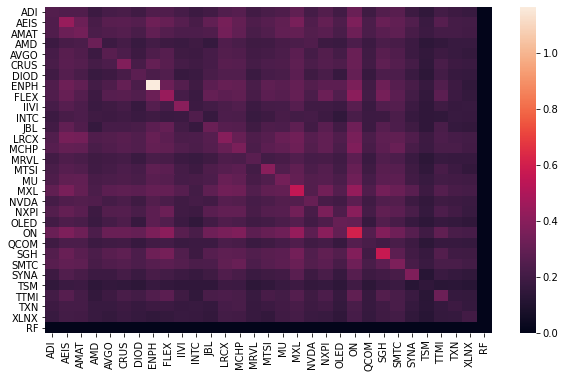

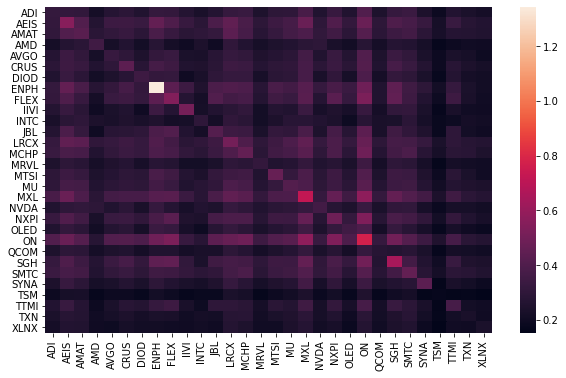

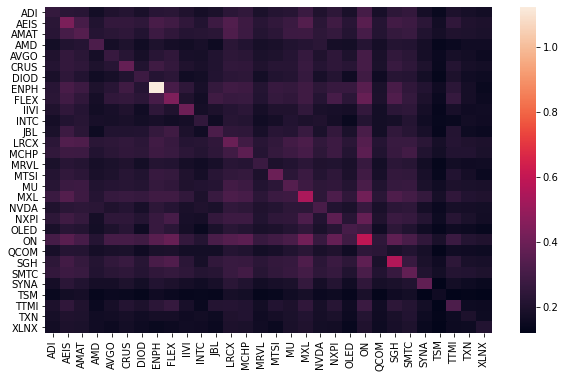

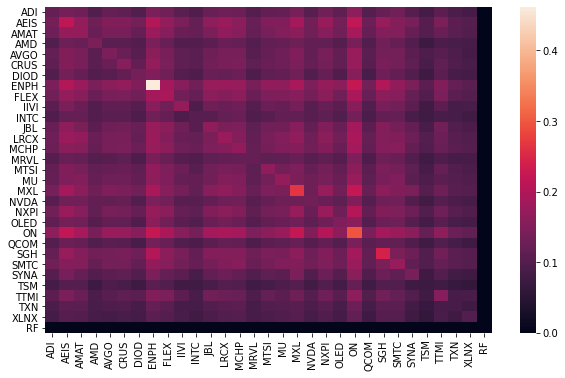

In [35]:
fig, ax = plt.subplots(figsize=(10,6))
_=sns.heatmap(ax=ax, data=S) # sample cov

fig, ax = plt.subplots(figsize=(10,6)) 
_=sns.heatmap(ax=ax, data=risk_models.exp_cov(in_sample_window,span=252,returns_data=True)) # shrinkage cov

fig, ax = plt.subplots(figsize=(10,6)) 
_=sns.heatmap(ax=ax, data=risk_models.CovarianceShrinkage(in_sample_window, returns_data=True).ledoit_wolf('constant_variance')) # shrinkage cov

fig, ax = plt.subplots(figsize=(10,6)) 
_=sns.heatmap(ax=ax, data=adj_S) # semi cov

# 2.2 Portfolio Allocation
Convert the continuous weight values into an integer allocation (You can't buy half a 0.05 of a stock, for example). Using discrete allocation, we can buy the closest number of shares that gets us to the desired weightage. 

We use the Integer Programming method provided by Martin, R. A., (2021) in his PyPortfolioOpt library to generate the allocation closest to our desired weights. The method was first implemented by Dingyuan Wang (https://github.com/gumblex), and adapted by the the creator of PyPortfolioOpt for use in his API. 

Integer Programming approaches the problem of allocation by searching the space of possible allocations to find the closest match to our calculated weights. It is essentially an optimization problem, minimizing:
$$r = T - x*P$$
where:
- $r$ = remaining unallocated value
- $T$ = Total amount available for allocation
- $x$ = integer allocation
- $p$ = price of the stock


In [36]:
# collect prices at 2020-12-31
latest_prices = {}
for ticker, df in stocks_30.items():
    latest_prices[ticker] = df['Adj Close'][df.Date == '2020-12-31'].values[0]
latest_prices = pd.Series(latest_prices)
latest_prices['RF'] = 100/1.01
results = dict(sorted(continuous_weights.to_dict().items()))

Assume risk-free assets = 1 year risk-free zero coupon bond with 1% YTM until told otherwise, with face value = \$100

In [37]:
# allocate money
T=5000000000 # 5 billion
allocation = discrete_allocation.DiscreteAllocation(weights = results, latest_prices = latest_prices, total_portfolio_value=T)

#!pip install cvxopt # to get access to the solver used in the allocation

discrete_allo = allocation.greedy_portfolio(verbose=True)
portfolio_value = T-discrete_allo[1]
print(f"Portfolio value: ${portfolio_value}")

Funds remaining: 2.66
ENPH: allocated 0.155, desired 0.155
NVDA: allocated 0.105, desired 0.105
MTSI: allocated 0.084, desired 0.084
IIVI: allocated 0.068, desired 0.068
MRVL: allocated 0.060, desired 0.060
LRCX: allocated 0.053, desired 0.053
MXL: allocated 0.039, desired 0.039
AMD: allocated 0.036, desired 0.036
AEIS: allocated 0.032, desired 0.032
MCHP: allocated 0.030, desired 0.030
SYNA: allocated 0.027, desired 0.027
QCOM: allocated 0.025, desired 0.025
AMAT: allocated 0.024, desired 0.024
ON: allocated 0.024, desired 0.024
DIOD: allocated 0.023, desired 0.023
TSM: allocated 0.023, desired 0.023
AVGO: allocated 0.022, desired 0.022
SMTC: allocated 0.021, desired 0.021
ADI: allocated 0.019, desired 0.019
MU: allocated 0.018, desired 0.018
NXPI: allocated 0.018, desired 0.018
RF: allocated 0.016, desired 0.016
TXN: allocated 0.014, desired 0.014
INTC: allocated 0.013, desired 0.013
XLNX: allocated 0.011, desired 0.011
TTMI: allocated 0.011, desired 0.011
SGH: allocated 0.010, desir

In [38]:
# print integer allocation
print(f"Integer Allocation")
pd.Series(discrete_allo[0])

Integer Allocation


ENPH    4404395
NVDA    4041732
MTSI    7617693
IIVI    4459852
MRVL    6295926
LRCX     567341
MXL     5143754
AMD     1987147
AEIS    1641742
MCHP    1084563
SYNA    1385047
QCOM     840244
AMAT    1421409
ON      3678185
DIOD    1641252
TSM     1072430
AVGO     253158
SMTC    1477611
ADI      661054
MU      1196256
NXPI     560811
RF       821049
TXN      429811
INTC    1349656
XLNX     384883
TTMI    3909703
SGH     1285577
JBL     1119247
FLEX    2617895
CRUS       4298
dtype: int64

In [39]:
# print actual weights
print("Actual Weights")
actual_weights = (pd.Series(discrete_allo[0])*latest_prices)/portfolio_value
comparison_table['actual weights'] = actual_weights.fillna(0)
print(comparison_table['actual weights'])

Actual Weights
Ticker Symbol Given by the Exchange
SYNA    0.026704
MRVL    0.059727
SGH     0.009675
ENPH    0.154568
JBL     0.009476
CRUS    0.000071
MCHP    0.029709
AEIS    0.031739
MTSI    0.083856
AMAT    0.024400
NVDA    0.105450
ON      0.024077
TTMI    0.010791
SMTC    0.021304
AVGO    0.021667
XLNX    0.010913
TSM     0.023116
IIVI    0.067754
QCOM    0.025232
NXPI    0.017685
FLEX    0.009414
DIOD    0.023142
AMD     0.036448
MXL     0.039288
ADI     0.019285
INTC    0.013199
TXN     0.013870
LRCX    0.053220
MU      0.017962
OLED    0.000000
RF      0.016258
Name: actual weights, dtype: float64


# 2.3. Evaluation

Add any other relevant data.
Even if we don't need to compare old vs new portfolio, we still need this data for VaR calculations

In [40]:
#to flag out significant changes to be explained in question 3
comparison_table['percentage difference'] = (comparison_table['actual weights']-comparison_table['original weights'])*100/comparison_table['original weights']
comparison_table['percentage difference (abs)'] = comparison_table['percentage difference'].abs()

comparison_table.sort_values("percentage difference (abs)", ascending=False)

,original weights,1,2,3,4,5,6,actual weights,percentage difference,percentage difference (abs)
Ticker Symbol Given by the Exchange,,,,,,,,,,
RF,0.000000,0.05,0.07,0.07,0.04,0.03,0.02,0.016258,inf,inf
MTSI,0.007033,0.25,0.11,0.11,0.08,0.08,0.08,0.083856,1092.351965,1092.351965
IIVI,0.009929,0.00,0.04,0.04,0.07,0.07,0.07,0.067754,582.410559,582.410559
MXL,0.006205,0.00,0.00,0.00,0.03,0.04,0.04,0.039288,533.125829,533.125829
SYNA,0.005068,0.20,0.10,0.10,0.03,0.03,0.03,0.026704,426.935007,426.935007
ENPH,0.029372,0.25,0.13,0.13,0.14,0.14,0.15,0.154568,426.238288,426.238288
AEIS,0.007550,0.00,0.02,0.02,0.03,0.03,0.03,0.031739,320.394700,320.394700
SMTC,0.005378,0.00,0.00,0.00,0.02,0.02,0.02,0.021304,296.134953,296.134953
DIOD,0.009412,0.00,0.03,0.03,0.02,0.02,0.02,0.023142,145.886362,145.886362


In [41]:
comparison_table['6']

Ticker Symbol Given by the Exchange
SYNA    0.03
MRVL    0.06
SGH     0.01
ENPH    0.15
JBL     0.01
CRUS    0.00
MCHP    0.03
AEIS    0.03
MTSI    0.08
AMAT    0.02
NVDA    0.11
ON      0.02
TTMI    0.01
SMTC    0.02
AVGO    0.02
XLNX    0.01
TSM     0.02
IIVI    0.07
QCOM    0.03
NXPI    0.02
FLEX    0.01
DIOD    0.02
AMD     0.04
MXL     0.04
ADI     0.02
INTC    0.01
TXN     0.01
LRCX    0.05
MU      0.02
OLED    0.00
RF      0.02
Name: 6, dtype: float64

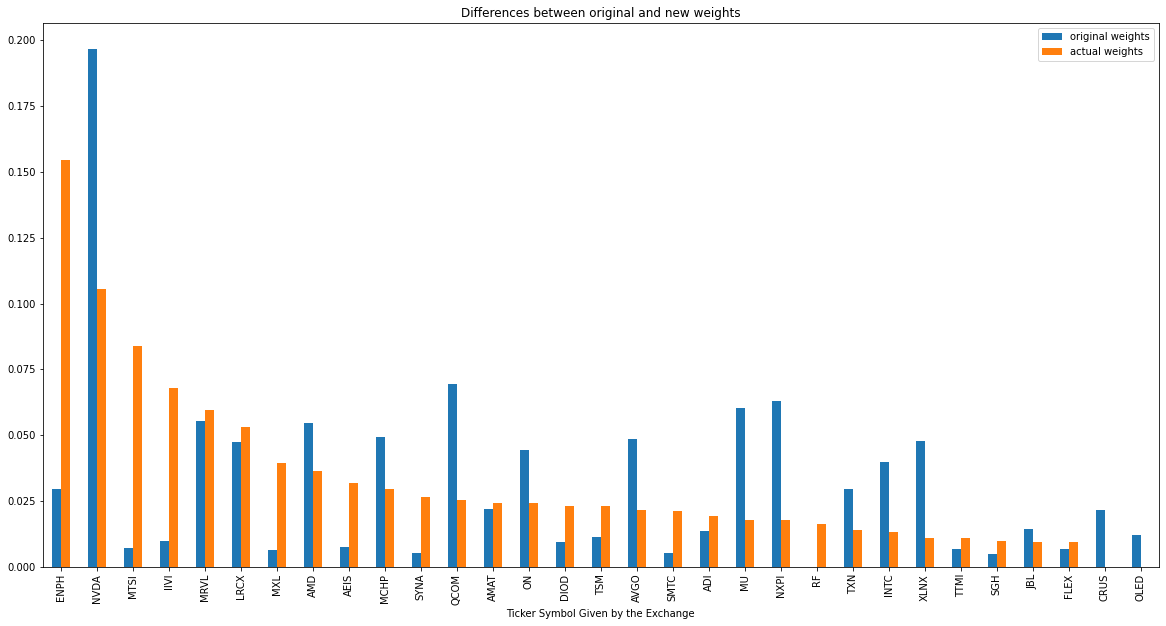

In [42]:
import matplotlib.pyplot as plt
comparison_table.sort_values("actual weights", ascending=False, inplace=True)
_ = comparison_table.loc[:,["original weights","actual weights"]].plot(kind='bar', figsize=(20,10), title = 'Differences between original and new weights')

# Q4 VaR and ES


In [71]:
def get_historical_risk(returns_df, rolling_window_size, dates, weights, decay=0.98, risk_free_rate = 0.01):
    '''
    Function to obtain the historical risk given the dates provided. Assumes 5% VaR and 5% ES.
    
    Parameters:
    - returns_df (pd.DataFrame): Dataframe of the daily percentage returns. Tickers in the columns, and dates in the index. 
    - rolling_window_size (int): Integer ditating the size of the rolling window to consider when calculating the historical risk.
    - dates (list-like): Integer or list-like object containing the dates to calculate historical VaR for.
    - weights (pd.Series): Pandas series object containing the weights of each investment. Index is the ticker names for each investment.
    
    Returns:
    - risk_df (pd.DataFrame): Dataframe of the log VaR and ES of each provided date. Dates are the index.
    '''
    
    if isinstance(dates, dict):
        if ('start_date' or 'end_date') not in dates.keys():
            raise ValueError("Missing start_date or end_date variable.")
        start_date = dates['start_date']
        end_date = dates['end_date']
        dates = returns_df[(returns_df.index>=start_date)&(returns_df.index<=end_date)].index.values
    
    elif not isinstance(dates, list):
        dates = [dates,]
    
    not_found = [date for date in dates if date not in returns_df.index]
    if any(not_found):
        raise ValueError(f"{not_found} not found in provided data")
        
    returns_df.loc[:,'RF'] = (1+risk_free_rate)**(1/252) -1
        
    historical_returns = np.log((returns_df*weights).sum(axis=1)+1) # calculate the historical returns of the portfolio after weighting, then log it
    historical_var = np.zeros(len(dates)) # create empty array for fast data read/write
    historical_ES = np.zeros(len(dates)) # create empty array for fast data read/write
    
    for day_index in range(len(dates)): # for each date
        date = dates[day_index]
        rolling_window = historical_returns[historical_returns.index<date].iloc[-rolling_window_size:]
        historical_var[day_index] = np.percentile(rolling_window,5) # get 5% percentile for VaR
        sum_of_loss_returns = np.sum(rolling_window.iloc[np.where(rolling_window < historical_var[day_index])]) # formula for ES, select all values lower than the 5% VaR and sum them.\n",
        historical_ES[day_index] = sum_of_loss_returns/(rolling_window_size*0.05) # formula for ES
        #risk_df = pd.DataFrame([historical_var,historical_ES],index=['5% VaR', '5% ES'],columns=dates).T
    
    # Convert to arithmetic returns
    historical_var = np.exp(historical_var)-1
    historical_ES = np.exp(historical_ES)-1
    risk_df = pd.DataFrame([historical_var,historical_ES],index=['5% VaR', '5% ES'],columns=dates).T
    return risk_df
        

In [72]:
# NOTE: LOG

def get_parametric_risk(returns_df, rolling_window_size, dates, weights, risk_free_rate = 0.01):
    '''
    Function to obtain the parametric risk given the dates provided. Assumes 5% VaR and 5% ES, and normal distribution.
    Variance is calculated as 
    
    Parameters:
    - returns_df (pd.DataFrame): Dataframe of the daily percentage returns. Tickers in the columns, and dates in the index. 
    - rolling_window_size (int): Integer ditating the size of the rolling window to consider when calculating the historical risk.
    - dates (list-like): Integer or list-like object containing the dates to calculate historical VaR for.
    - weights (pd.Series): Pandas series object containing the weights of each investment. Index is the ticker names for each investment.
    
    Returns:
    - risk_df (pd.DataFrame): Dataframe of the log VaR and ES of each provided date. Dates are the index.
    '''
    
    if isinstance(dates, dict):
        if ('start_date' or 'end_date') not in dates.keys():
            raise ValueError("Missing start_date or end_date variable.")
        start_date = dates['start_date']
        end_date = dates['end_date']
        dates = returns_df[(returns_df.index>=start_date)&(returns_df.index<=end_date)].index.values
    
    elif not isinstance(dates, list):
        dates = [dates,]
    
    not_found = [date for date in dates if date not in returns_df.index]
    if any(not_found):
        raise ValueError(f"{not_found} not found in provided data")
        
    returns_df.loc[:,'RF'] = (1+risk_free_rate)**(1/252) -1
        
    parametric_var = np.zeros(len(dates)) # create empty array for fast data read/write
    parametric_ES = np.zeros(len(dates)) # create empty array for fast data read/write
    
    for day_index in range(len(dates)): # for each date
        date = dates[day_index]
        
        individual_window = returns_df[returns_df.index<date].iloc[-rolling_window_size:] # collect the values for the logreturns for each individual stock, inclusive of the day itself
        
        # calculate mean
        mu = expected_returns.mean_historical_return(individual_window, returns_data=True) # this gives annual returns
        mu = (mu+1)**(1/252)-1 # convert to daily results
        log_mean_return = np.log((mu.values*weights).sum() +1) # in log
        
        # calculate variance 
        S = np.log(risk_models.sample_cov(individual_window, returns_data=True)/252+1) # get shrinkage covariance matrix, divide by 252 to get daily values, then log it
        
        variance_return = np.dot(weights, np.dot(S, weights)) # calculate portfolio variance

        # calculate VaR and ES
        volatility = variance_return**0.5
        z_alpha = norm.ppf(0.05)
        parametric_var[day_index] = log_mean_return + volatility*z_alpha
        parametric_ES[day_index] = log_mean_return-volatility*(norm.pdf(norm.ppf(0.05))/0.05)
    
    # convert to arithmetic returns
    parametric_var = np.exp(parametric_var)-1
    parametric_ES = np.exp(parametric_ES)-1
    risk_df = pd.DataFrame([parametric_var,parametric_ES],index=['5% VaR', '5% ES'],columns=dates).T
    
    return risk_df

In [73]:
# choose dates (dict for range, or list-like for specific dates)
dates = {"start_date":"2020-12-31","end_date":"2021-6-30"}

### Risk for original portfolio

In [89]:
original_table = pd.DataFrame((simple_returns[(simple_returns.index<=dates['end_date']) & (simple_returns.index>=dates['start_date'])]).mean(1))
original_table.rename(columns={0:"Simple Returns"},inplace=True)
historical_risk_values = get_historical_risk(returns_df=simple_returns, rolling_window_size=252, dates=dates, weights=comparison_table['original weights'])
original_table['Historical VaR'] = historical_risk_values['5% VaR']
original_table['Historical ES'] = historical_risk_values['5% ES']
parametric_risk_values = get_parametric_risk(returns_df=simple_returns, rolling_window_size=252, dates=dates, weights=comparison_table['original weights'])
original_table['Parametric VaR'] = parametric_risk_values['5% VaR']
original_table['Parametric ES'] = parametric_risk_values['5% ES']

In [90]:
original_table

,Simple Returns,Historical VaR,Historical ES,Parametric VaR,Parametric ES
Date,,,,,
2020-12-31,0.004946,-0.048070,-0.078918,-0.050926,-0.063803
2021-01-04,-0.002829,-0.048070,-0.078918,-0.050952,-0.063815
2021-01-05,0.022144,-0.048070,-0.078918,-0.050880,-0.063739
2021-01-06,0.011347,-0.048070,-0.078918,-0.050788,-0.063660
2021-01-07,0.034703,-0.048070,-0.078918,-0.050788,-0.063661
...,...,...,...,...,...
2021-06-24,0.018071,-0.033225,-0.047806,-0.031891,-0.040291
2021-06-25,0.000823,-0.033225,-0.047806,-0.031595,-0.039970
2021-06-28,0.021976,-0.033225,-0.047806,-0.031606,-0.039979


### Risk for worst-performing portfolio

In [76]:
# load stocks into a dictionary
bad_fund = {}
do_not_append = [] 
for file_name in os.listdir('worst_data/'):
  ticker = file_name.split(".")[0]
  if ticker in do_not_append:
    pass
  else:
    bad_fund[f'{ticker}'] = pd.read_csv(f'worst_data/{file_name}') # for each stock, add its ticker as the key and dataframe as the value

In [77]:
print(list(bad_fund.keys())) # print the stock tickers for easy referencing

['AAPL', 'ABBV', 'ADBE', 'ADP', 'ADSK', 'AMZN', 'ANTM', 'BAH', 'EBIX', 'EEFT', 'ENS', 'EPAM', 'EXTR', 'G', 'GOOG', 'GPN', 'IIVI', 'IQV', 'JBL', 'MA', 'MSFT', 'NXPI', 'PRFT', 'QRVO', 'ROG', 'ST', 'SWKS', 'TEL', 'THR', 'UNH', 'V']


In [78]:
# Change date column into a datetime object
# Add a new column for log returns
for ticker, df in bad_fund.items():
  df['Date'] = df['Date'].apply(pd.to_datetime)
  df['LogReturns'] = np.append(np.nan,np.diff(np.log(df['Adj Close']))) # Fill dataframe with the log returns. The first value will be nan because there is no log returns for it.

In [79]:
# preview a stock
bad_fund['AAPL'].head()

,Date,Open,High,Low,Close,Adj Close,Volume,LogReturns
0,2016-10-04,28.264999,28.577499,28.157499,28.250000,26.493998,118947200,NaN
1,2016-10-05,28.350000,28.415001,28.172501,28.262501,26.505718,85812400,0.000442
2,2016-10-06,28.424999,28.584999,28.282499,28.472500,26.702660,115117200,0.007403
3,2016-10-07,28.577499,28.639999,28.377501,28.514999,26.742519,97433600,0.001492
4,2016-10-10,28.754999,29.187500,28.680000,29.012501,27.209097,144944000,0.017297


In [80]:
bad_fund_log_returns = pd.DataFrame(data=np.full((bad_fund['AAPL'].shape[0],31),np.nan), columns = sorted(list(bad_fund.keys())), index = bad_fund['AAPL'].Date) # create empty dataframe filled with NaNs, with index = Date and columns = stocks

# copy the log returns
for ticker, df in bad_fund.items():
  bad_fund_log_returns[ticker] = bad_fund_log_returns.index.map(bad_fund[ticker].set_index('Date')['LogReturns'])

# if simple returns are needed
bad_fund_simple_returns = np.exp(bad_fund_log_returns)-1
# set bad fund earliest date to the same as the good fund
bad_fund_simple_returns = bad_fund_simple_returns[bad_fund_simple_returns.index>=simple_returns.index[0]]

In [81]:
# get bad portfolio weights
bad_portfolio = pd.read_csv('original_weights_worst.csv')
bad_portfolio.index = bad_portfolio['Ticker Symbol Given by the Exchange']
del bad_portfolio['Ticker Symbol Given by the Exchange']
bad_portfolio['Security\'s Percentage of the Total Net Assets'] = bad_portfolio['Security\'s Percentage of the Total Net Assets']/100 

In [82]:
bad_table = pd.DataFrame((bad_fund_simple_returns[(bad_fund_simple_returns.index<=dates['end_date']) & (bad_fund_simple_returns.index>=dates['start_date'])]).mean(1))
bad_table.rename(columns={0:"Simple Returns"},inplace=True)
historical_risk_values = get_historical_risk(returns_df=bad_fund_simple_returns, rolling_window_size=252, dates=dates, weights=bad_portfolio['Security\'s Percentage of the Total Net Assets'])
bad_table['Historical VaR'] = historical_risk_values['5% VaR']
bad_table['Historical ES'] = historical_risk_values['5% ES']
parametric_risk_values = get_parametric_risk(returns_df=bad_fund_simple_returns, rolling_window_size=252, dates=dates, weights=bad_portfolio['Security\'s Percentage of the Total Net Assets'])
bad_table['Parametric VaR'] = parametric_risk_values['5% VaR']
bad_table['Parametric ES'] = parametric_risk_values['5% ES']

In [83]:
bad_table

,Simple Returns,Historical VaR,Historical ES,Parametric VaR,Parametric ES
Date,,,,,
2020-12-31,0.006601,-0.037717,-0.071795,-0.041069,-0.051453
2021-01-04,-0.015665,-0.037717,-0.071795,-0.041079,-0.051460
2021-01-05,0.013841,-0.037717,-0.071795,-0.041151,-0.051539
2021-01-06,0.014336,-0.037717,-0.071795,-0.041128,-0.051521
2021-01-07,0.020559,-0.037717,-0.071795,-0.041106,-0.051501
...,...,...,...,...,...
2021-06-24,0.009519,-0.022149,-0.031672,-0.019734,-0.025048
2021-06-25,0.002041,-0.021973,-0.030505,-0.019196,-0.024423
2021-06-28,-0.003239,-0.021973,-0.030505,-0.019209,-0.024426


### Risk for new portfolio

In [84]:
new_table = pd.DataFrame((simple_returns[(simple_returns.index<=dates['end_date']) & (simple_returns.index>=dates['start_date'])]).mean(1))
new_table.rename(columns={0:"Simple Returns"},inplace=True)
historical_risk_values = get_historical_risk(returns_df=simple_returns, rolling_window_size=252, dates=dates, weights=comparison_table['actual weights'])
new_table['Historical VaR'] = historical_risk_values['5% VaR']
new_table['Historical ES'] = historical_risk_values['5% ES']
parametric_risk_values = get_parametric_risk(returns_df=simple_returns, rolling_window_size=252, dates=dates, weights=comparison_table['actual weights'])
new_table['Parametric VaR'] = parametric_risk_values['5% VaR']
new_table['Parametric ES'] = parametric_risk_values['5% ES']

In [85]:
new_table

,Simple Returns,Historical VaR,Historical ES,Parametric VaR,Parametric ES
Date,,,,,
2020-12-31,0.004946,-0.048842,-0.084644,-0.049437,-0.061974
2021-01-04,-0.002829,-0.048842,-0.084644,-0.049464,-0.061988
2021-01-05,0.022144,-0.048842,-0.084644,-0.049393,-0.061913
2021-01-06,0.011347,-0.048842,-0.084644,-0.049296,-0.061825
2021-01-07,0.034703,-0.048842,-0.084644,-0.049299,-0.061826
...,...,...,...,...,...
2021-06-24,0.018071,-0.034017,-0.051805,-0.030711,-0.038833
2021-06-25,0.000823,-0.034017,-0.051805,-0.030456,-0.038559
2021-06-28,0.021976,-0.034017,-0.051805,-0.030471,-0.038574


## Plot VaR and ES comparisons

The chosen bad portfolio has a much better VaR and ES. This can be explained by it having a lower variance compared to our portfolio.

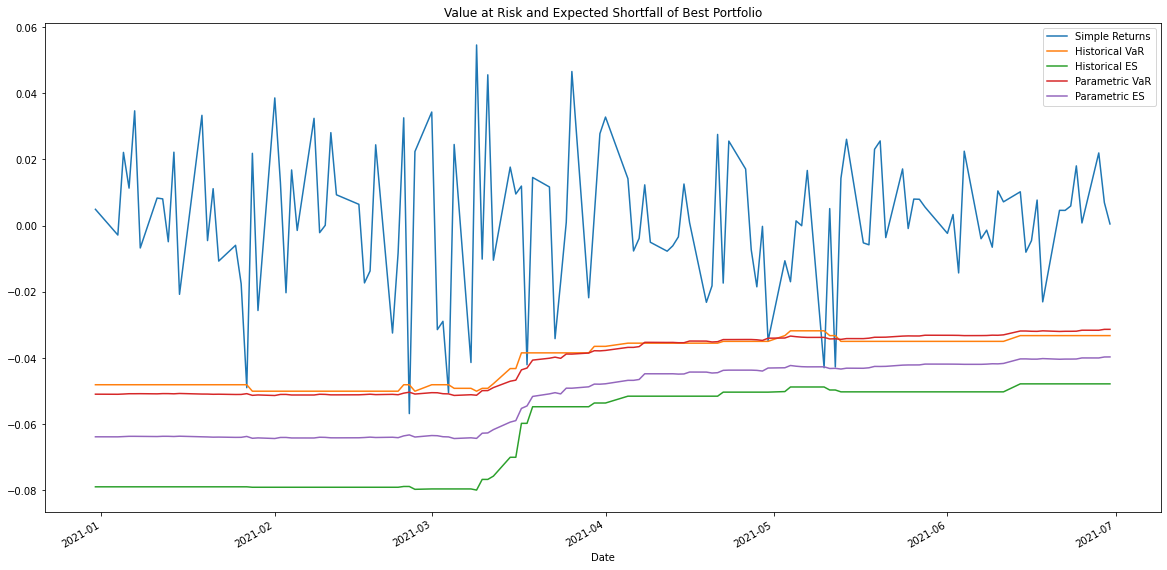

In [86]:
original_table.plot(figsize=(20,10))
plt.legend()
plt.title("Value at Risk and Expected Shortfall of Best Portfolio")
plt.show()

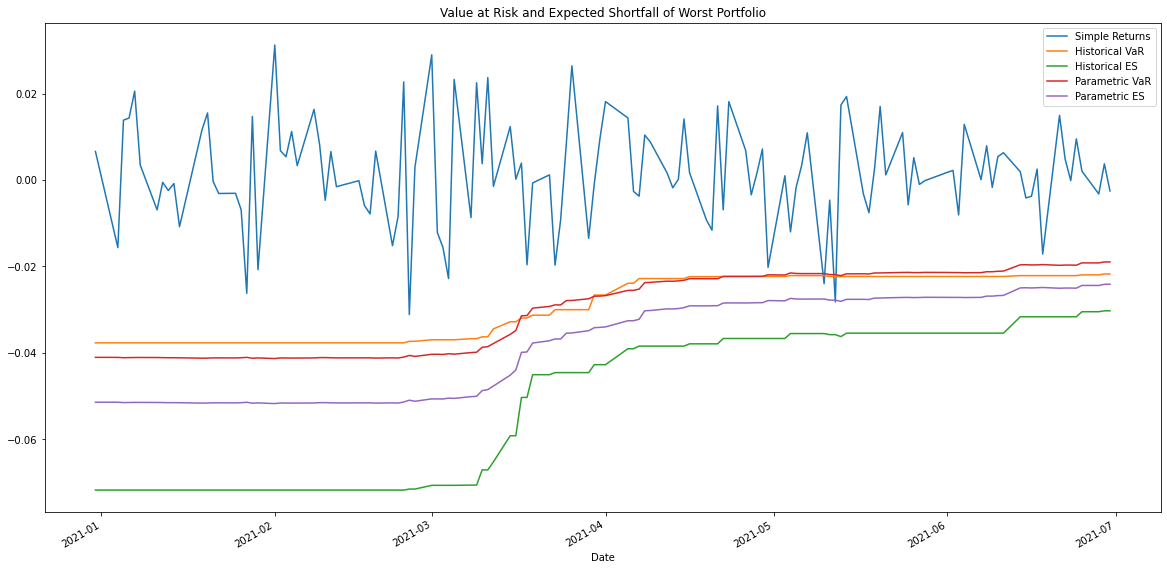

In [87]:
bad_table.plot(figsize=(20,10))
plt.legend()
plt.title("Value at Risk and Expected Shortfall of Worst Portfolio")
plt.show()

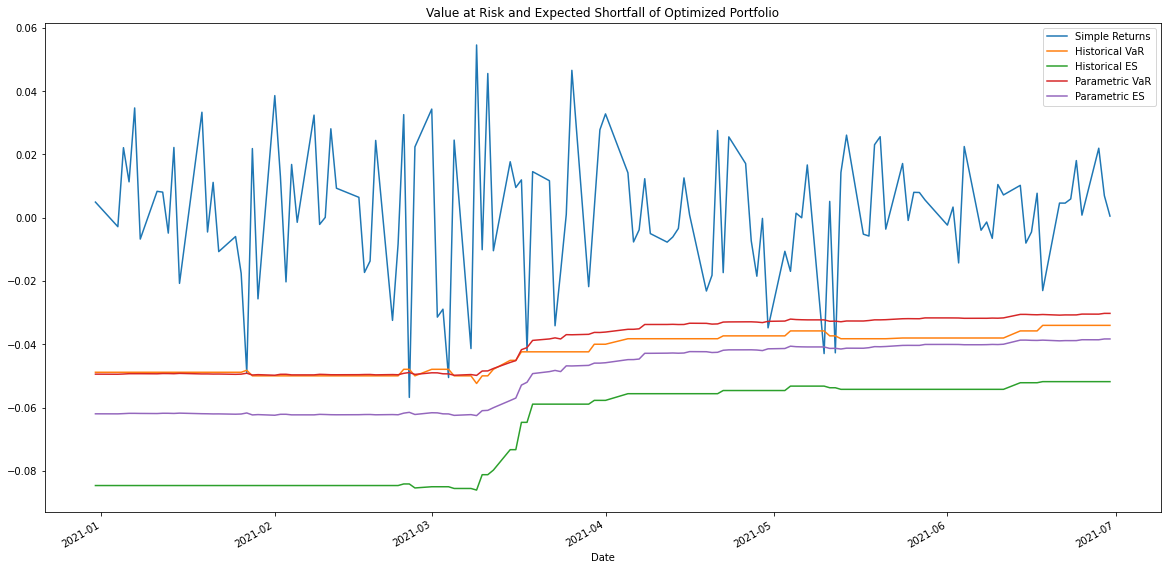

In [88]:
new_table.plot(figsize=(20,10))
plt.legend()
plt.title("Value at Risk and Expected Shortfall of Optimized Portfolio")
plt.show()

# Q5 Backtesting

## Helper functions

In [61]:
backtest_start = '2021-01-01'
backtest_end = '2021-06-30'

# Get portfolio value
def portfolio_returns(returns_df, weights, start, end):
    # Get only the period we want
    testing_period_mask = (returns_df.index<=end) & (returns_df.index >= start)
    testing_period_df = returns_df[testing_period_mask]
    
    # Calculate historical log returns of the portfolio
    historical_returns = np.log((testing_period_df*weights).sum(axis=1)+1)
    
    # Put it in a dataframe
    historical_returns = pd.DataFrame(historical_returns, columns=['log_returns'])
    historical_returns['next_day_log_returns'] = historical_returns['log_returns'].shift(-1)
    return historical_returns

def run_backtesting(returns, parametric_risk, historical_risk, backtesting_alpha=0.01):
    # parametric 95% VaR 
    returns_95_VaR_par = returns.copy()
    returns_95_VaR_par['risk'] = parametric_risk['5% VaR']
    
    # parametric 95% ES
    # returns_95_ES_par = returns.copy()
    # returns_95_ES_par['risk'] = parametric_risk['5% ES']
    
    # historical 95% VaR 
    returns_95_VaR_hist = returns.copy()
    returns_95_VaR_hist['risk'] = historical_risk['5% VaR']
    
    # historical 95% ES
    # returns_95_ES_hist = returns.copy()
    # returns_95_ES_hist['risk'] = historical_risk['5% ES']
    
    backtest_order = (returns_95_VaR_par, returns_95_VaR_hist)
    backtest_type = ('Parametric 95% VaR','Historical 95% VaR')
    
    for test,df in zip(backtest_type, backtest_order):
        # Carry out backtesting
        observed_level = 1-len(df[df['risk'] > df['next_day_log_returns']])/len(df)
        observations = len(df)
        failures = len(df[df['risk'] > df['next_day_log_returns']])
        expected = observations * 0.05
        ratio = failures/expected
        p_value_95 = 1-binom.cdf(failures,observations,0.05)
        
        print(test)
        print(f"\tObservations: {observations}")
        print(f"\tFailures: {failures}")
        print(f"\tExpected: {expected}")
        print(f"\tRatio: {ratio:.2f}")
        print(f"\tp-value of {test}: {p_value_95}")
        if (p_value_95 < backtesting_alpha):
            print("\tReject null hypothesis under binomial distribution")
        else:
            print(f"\tNot enough evidence to reject null hypothesis at {backtesting_alpha} backtesting significance level under binomial distribution")
        print()    
    return

## Bad fund

In [62]:
bad_fund_weights = bad_portfolio['Security\'s Percentage of the Total Net Assets']

bad_funds_backtest = portfolio_returns(bad_fund_simple_returns,bad_fund_weights, backtest_start, backtest_end)
bad_funds_parametric_risk = get_parametric_risk(returns_df=bad_fund_simple_returns, rolling_window_size=250, dates=dates, weights=bad_fund_weights)
bad_funds_historical_risk = get_historical_risk(returns_df=bad_fund_simple_returns, rolling_window_size=250, dates=dates, weights=bad_fund_weights)

In [63]:
run_backtesting(bad_funds_backtest, bad_funds_parametric_risk, bad_funds_historical_risk, backtesting_alpha=0.05)

Parametric 95% VaR
	Observations: 124
	Failures: 3
	Expected: 6.2
	Ratio: 0.48
	p-value of Parametric 95% VaR: 0.8723071485270615
	Not enough evidence to reject null hypothesis at 0.05 backtesting significance level under binomial distribution

Historical 95% VaR
	Observations: 124
	Failures: 2
	Expected: 6.2
	Ratio: 0.32
	p-value of Historical 95% VaR: 0.950470222321313
	Not enough evidence to reject null hypothesis at 0.05 backtesting significance level under binomial distribution



## Original(Best) Fund

In [64]:
orig_funds_weights = comparison_table['original weights']

orig_funds_backtest = portfolio_returns(simple_returns, orig_funds_weights, backtest_start, backtest_end)
orig_funds_parametric_risk = get_parametric_risk(returns_df=simple_returns, rolling_window_size=252, dates=dates, weights=orig_funds_weights)
orig_funds_historical_risk = get_historical_risk(returns_df=simple_returns, rolling_window_size=252, dates=dates, weights=orig_funds_weights)

In [65]:
run_backtesting(orig_funds_backtest, orig_funds_parametric_risk, orig_funds_historical_risk, backtesting_alpha = 0.05)

Parametric 95% VaR
	Observations: 124
	Failures: 6
	Expected: 6.2
	Ratio: 0.97
	p-value of Parametric 95% VaR: 0.42658447086514895
	Not enough evidence to reject null hypothesis at 0.05 backtesting significance level under binomial distribution

Historical 95% VaR
	Observations: 124
	Failures: 7
	Expected: 6.2
	Ratio: 1.13
	p-value of Historical 95% VaR: 0.2810038641342014
	Not enough evidence to reject null hypothesis at 0.05 backtesting significance level under binomial distribution



## Optimized Fund

In [66]:
opt_funds_weights = comparison_table['actual weights']

opt_funds_backtest = portfolio_returns(simple_returns, opt_funds_weights, backtest_start, backtest_end)
opt_funds_parametric_risk = get_parametric_risk(returns_df=simple_returns, rolling_window_size=252, dates=dates, weights=opt_funds_weights)
opt_funds_historical_risk = get_historical_risk(returns_df=simple_returns, rolling_window_size=252, dates=dates, weights=opt_funds_weights)

In [67]:
run_backtesting(opt_funds_backtest, opt_funds_parametric_risk, opt_funds_historical_risk, backtesting_alpha = 0.05)

Parametric 95% VaR
	Observations: 124
	Failures: 7
	Expected: 6.2
	Ratio: 1.13
	p-value of Parametric 95% VaR: 0.2810038641342014
	Not enough evidence to reject null hypothesis at 0.05 backtesting significance level under binomial distribution

Historical 95% VaR
	Observations: 124
	Failures: 7
	Expected: 6.2
	Ratio: 1.13
	p-value of Historical 95% VaR: 0.2810038641342014
	Not enough evidence to reject null hypothesis at 0.05 backtesting significance level under binomial distribution



#  Q6

## Black-Litterman allocation
- L2 regularization with gamma = 5
- Mean and Variance are estimated using black-litterman allocation
- Black-Litterman allocation's view is estimated with the EMA of the mean.
- Sub-sectors by market cap

Refer: https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html

Unless there's a large flaw in the logic of using EMA as the view, I expect we'll be using this method as our chosen method.

In [68]:
k = 1.528 
def calc_risk_aversion(market_returns, frequency = 252, risk_free_rate = 0.01):
    '''
    Function to obtain the the risk aversion of individual funds given the market returns. A modification of the market_implied_risk_aversion function from pypfopt's black_litterman implementation.
    This modification takes in the daily market returns instead of the daily market prices. The original function also returns values un-compounded. Here, they are compounded.
    
    Parameters:
    - market_returns (pd.DataFrame): Dataframe of the daily percentage returns. Tickers in the columns, and dates in the index. 
    - frequency (int, optional): number of time periods in a year, defaults to 252 (the number of trading days in a year)
    - risk_free_rate (float, optional): risk-free rate of borrowing/lending, defaults to 0.01. The period of the risk-free rate should correspond to the frequency of expected returns.
    
    Returns:
    - market-implied risk aversion (pd.Series)
    '''
    
    r = (1+market_returns.mean()) ** frequency - 1
    var = market_returns.var() * frequency
    return (r - risk_free_rate) / var

# read and process market cap data into a suitable format
market_caps = pd.read_csv('market_cap_data.csv')
market_caps2 = pd.Series(data=market_caps['MARKET CAP IN BILLIONS'].values)
market_caps2.index = market_caps['TICKER'].values
market_caps = market_caps2[market_caps2.index != 'RF']
market_caps = market_caps.sort_index()

# use the black-litterman allocation to generate the adjusted mean and variance

cov_matrix = risk_models.sample_cov(in_sample_window, returns_data=True) # using a shrinkage covariance estimator

risk_aversion = calc_risk_aversion(in_sample_window, frequency=252, risk_free_rate=0.01)
prior_returns = black_litterman.market_implied_prior_returns(market_caps, risk_aversion, cov_matrix, risk_free_rate=0.01) # priors can be thought of the default estimate, in absense of information. 
                                                                                                                          # A natural choice for this prior is the market’s estimate of the return, 
                                                                                                                          # which is embedded into the market capitalisation of the asset.


views = expected_returns.ema_historical_return(in_sample_window, span=252, returns_data=True) # here, we use the exponentially moving average mean historical return to represent our views on how the stock will grow

bl_model = black_litterman.BlackLittermanModel(cov_matrix, pi=prior_returns, absolute_views=views, risk_aversion=k) 

adj_mu = bl_model.bl_returns() # posterior mean returns
adj_mu['RF'] = 0.01 # add risk-free assets
adj_S = bl_model.bl_cov() # posterior covariance
adj_S.loc['RF',:] = 0 # add risk-free assets
adj_S.loc[:,'RF'] = 0

In [69]:
ef = EfficientFrontier(adj_mu, adj_S, solver=solver)
k = 1.528 
print(f"k = {k}")

ef.add_constraint(lambda x: x >= 0) # weights >= 0
ef.add_constraint(lambda x: x <= 0.25) # weight <= 0.25

sector_mapper = {} # initialise sector_mapper
for stock in cat_1:
  sector_mapper[stock] = 'cat_1'
for stock in cat_2:
  sector_mapper[stock] = 'cat_2'
for stock in cat_3:
  sector_mapper[stock] = 'cat_3'
sector_mapper['RF'] = 'rf'

sector_lower = {'cat_1': 0.2, 'cat_2': 0.2, 'cat_3': 0.2} # at least 20% to each category
sector_upper = {'cat_1': 0.5, 'cat_2': 0.5, 'cat_3': 0.5} # not more than 50% to each category

ef.add_sector_constraints(sector_mapper=sector_mapper, sector_lower=sector_lower, sector_upper=sector_upper) # add sector constraint

sector_mapper2 = {} # initialise sector_mapper
for stock in semiconductors:
  sector_mapper2[stock] = 'semiconductors'
for stock in others:
  sector_mapper2[stock] = 'others'

sector_lower2 = {'others': 0.3} # at least 30% to others

ef.add_sector_constraints(sector_mapper=sector_mapper2, sector_lower=sector_lower2, sector_upper={}) # add sector constraint

ef.add_objective(objective_functions.L2_reg, gamma=5) # L2 regularisation parameter, defaults to 1. This adds a small weights penalty, gamma, to the objective function. Increase for more non-negligible weights. 

optimal_weights_portfolio = ef.max_quadratic_utility(risk_aversion = 2*k) # optimize by the quadratic utility function mean - k/2 * variance (hence the 2*k in the parameters)
results = pd.Series(np.array(list(optimal_weights_portfolio.values())),index = np.append(in_sample_window.columns, 'RF'))
_ = base_optimizer.portfolio_performance(results, mu, S, verbose=True, risk_free_rate=0.01)
print(np.round(results,4))
print('\n')
print(f'CAT 1: {results.loc[cat_1].sum()}, CAT 2: {results.loc[cat_2].sum()}, CAT 3: {results.loc[cat_3].sum()}')
# check against out of sample window
_ = base_optimizer.portfolio_performance(results, oos_mu, oos_S, verbose=True, risk_free_rate=0.01)

k = 1.528
Expected annual return: 75.8%
Annual volatility: 47.6%
Sharpe Ratio: 1.57
ADI     0.0139
AEIS    0.0275
AMAT    0.0254
AMD     0.0553
AVGO    0.0118
CRUS    0.0123
DIOD    0.0265
ENPH    0.1305
FLEX    0.0094
IIVI    0.0590
INTC    0.0224
JBL     0.0148
LRCX    0.0523
MCHP    0.0189
MRVL    0.0532
MTSI    0.0938
MU      0.0233
MXL     0.0045
NVDA    0.1224
NXPI    0.0073
OLED    0.0000
ON      0.0000
QCOM    0.0234
SGH     0.0056
SMTC    0.0078
SYNA    0.0510
TSM     0.0550
TTMI    0.0215
TXN     0.0141
XLNX    0.0000
RF      0.0373
dtype: float64


CAT 1: 0.3296262555442655, CAT 2: 0.29925133641329793, CAT 3: 0.3337977570805189
Expected annual return: 261.2%
Annual volatility: 30.6%
Sharpe Ratio: 8.51


In [70]:
comparison_table['BL allocation'] = np.round(results,2)